<a href="https://colab.research.google.com/github/amilkh/cs230-fer/blob/evaluate-test/fer2013.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 1.x

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import *

%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
data = pd.read_csv('/content/drive/My Drive/cs230 project/collab/fer2013/fer2013.csv')
data['pixels'] = data['pixels'].apply(lambda x: [int(pixel) for pixel in x.split()])

data_test = data[data['Usage']=='PrivateTest']

X_test, y_test = data_test['pixels'].tolist(), data_test['emotion'].values
# Reshape (m, width, height, num_channels) (grayscale means one channel)
X_test = np.array(X_test, dtype='float32').reshape(-1,48,48,1)
X_test = X_test/255.0 # normalize to 0.0-1.0

In [0]:
from keras.models import load_model
model = load_model('/content/drive/My Drive/cs230 project/models/soa-SGD_LR_0.01000-EPOCHS_100-BS_128-DROPOUT_0.5.h5') #64%

In [8]:
y_pred_test = model.predict(X_test).argmax(axis=1)

from tensorflow.keras.preprocessing.image import ImageDataGenerator
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        '/content/drive/My Drive/cs230 project/webcam images',
        target_size=(48, 48),
        color_mode='grayscale',
        shuffle = False,
        class_mode='categorical',
        batch_size=1)

y_pred_webcam = model.predict_generator(test_generator, steps=len(test_generator.filenames)).argmax(axis=1)
y_true_webcam = test_generator.classes

Found 84 images belonging to 7 classes.


In [9]:
incorrect_test = np.count_nonzero(y_pred_test-y_test)
incorrect_webcam = np.count_nonzero(y_true_webcam-y_pred_webcam)

print("Accuracy on FER2013 private test images: {:.2%}".format(1.0 - incorrect_test/len(y_test)))
print("Accuracy on webcam images: {:.2%}".format(1.0 - incorrect_webcam/len(y_pred_webcam)))

Accuracy on FER2013 private test images: 62.78%
Accuracy on webcam images: 28.57%


In [0]:
from sklearn.metrics import confusion_matrix
from seaborn import heatmap

emotions = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}

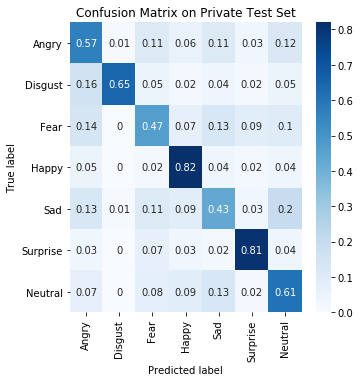

In [33]:
cmat_df_test=pd.DataFrame(
  confusion_matrix(y_test, y_pred_test, normalize='true').round(2),
  index=emotions.values(), 
  columns=emotions.values()
  )

plt.figure(figsize=(5,5))
heatmap(cmat_df_test,annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.title('Confusion Matrix on Private Test Set')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

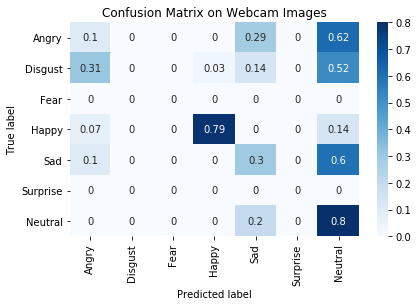

In [35]:
cmat_df_webcam=pd.DataFrame(
  confusion_matrix(y_true_webcam, y_pred_webcam, labels=np.arange(7), normalize='true').round(2),
  index=emotions.values(), 
  columns=emotions.values()
  )

heatmap(cmat_df_webcam,annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.title('Confusion Matrix on Webcam Images')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()